<a href="https://colab.research.google.com/github/KarkiAnuj17/Automatic-text-summarization/blob/main/Automatic_text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/dataset.zip", 'r')
zip_ref.extractall("/content/dataset")
zip_ref.close()

In [ ]:
import pandas as pd
import nltk
from tqdm import tqdm
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import cudf

In [ ]:
import pandas as pd

# File path of the dataset
path = "/content/dataset/cnn_dailymail/train.csv"

# Load the dataset
df = pd.read_csv(path)

# Print columns and shape for verification
print("Columns in the dataset:", df.columns)
print("Shape of the dataset:", df.shape)

# Split the dataset into two equal parts
split_index = len(df) // 20
train_part1 = df.iloc[:split_index]  # First half
train_part2 = df.iloc[split_index:]  # Second half

# Save the splits to new CSV files
train_part1.to_csv("/content/dataset/cnn_dailymail/train_part1.csv", index=False)
train_part2.to_csv("/content/dataset/cnn_dailymail/train_part2.csv", index=False)

print("Dataset has been split into two parts:")
print(f"Part 1: {train_part1.shape}")
print(f"Part 2: {train_part2.shape}")

Columns in the dataset: Index(['id', 'article', 'highlights'], dtype='object')
Shape of the dataset: (287113, 3)
Dataset has been split into two parts:
Part 1: (14355, 3)
Part 2: (272758, 3)


In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import cudf
import pandas as pd
from tqdm import tqdm
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
import re

# Map POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Preprocess each article
def preprocess_text(text):
    if pd.isna(text) or not text.strip():  # Handle empty or NaN
        return []
    sentences = sent_tokenize(text)
    # Initialize tools
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    # Normalize text: lowercase and remove special characters
    text = re.sub(r"[^a-zA-Z\s]", "", text).lower()

    # Split into sentences
    sentences = sent_tokenize(text)

    # Process each sentence
    processed_sentences = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        pos_tags = pos_tag(words)
        processed_words = [
            lemmatizer.lemmatize(word, get_wordnet_pos(pos))
            for word, pos in pos_tags
            if word not in stop_words and word.isalnum()
        ]
        if processed_words:
            processed_sentences.append(" ".join(processed_words))

    return processed_sentences

# Preprocess CSV file
def preprocess_csv(file_path, text_column):
    # Read CSV with cuDF
    df = cudf.read_csv(file_path)

    # Convert text column to pandas for processing
    text_series = df[text_column].to_pandas()

    # Apply preprocessing with tqdm progress bar
    tqdm.pandas()
    processed_text = text_series.progress_apply(preprocess_text)

    # Convert list of sentences into a string (so it can be saved in CSV)
    df["processed_text"] = processed_text.apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

    return df

# File path and column to preprocess
file_path = "/content/dataset/cnn_dailymail/train_part1.csv"
text_column = "article"

# Process and display results
processed_df = preprocess_csv(file_path, text_column)

# Save the preprocessed DataFrame (converted processed text to string)
processed_df.to_csv("/content/dataset/cnn_dailymail/train_part1_preprocessed.csv", index=False)
print("Preprocessed DataFrame:")
print(processed_df.head())


100%|██████████| 14355/14355 [06:59<00:00, 34.19it/s]


Preprocessed DataFrame:
                                         id  \
0  0001d1afc246a7964130f43ae940af6bc6c57f01   
1  0002095e55fcbd3a2f366d9bf92a95433dc305ef   
2  00027e965c8264c35cc1bc55556db388da82b07f   
3  0002c17436637c4fe1837c935c04de47adb18e9a   
4  0003ad6ef0c37534f80b55b4235108024b407f0b   

                                             article  \
0  By . Associated Press . PUBLISHED: . 14:11 EST...   
1  (CNN) -- Ralph Mata was an internal affairs li...   
2  A drunk driver who killed a young woman in a h...   
3  (CNN) -- With a breezy sweep of his pen Presid...   
4  Fleetwood are the only team still to have a 10...   

                                          highlights  \
0  Bishop John Folda, of North Dakota, is taking ...   
1  Criminal complaint: Cop used his role to help ...   
2  Craig Eccleston-Todd, 27, had drunk at least t...   
3  Nina dos Santos says Europe must be ready to a...   
4  Fleetwood top of League One after 2-0 win at S...   

                   

In [ ]:
import nltk
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
from nltk.tokenize import word_tokenize

# Function to vectorize sentences into TF-IDF features
def vectorize_sentences(sentences):
    vectorizer = TfidfVectorizer()
    return vectorizer.fit_transform(sentences)

# Function to extract central words based on co-occurrence graph and PageRank
def extract_central_words_with_graph(word_list):
    G = nx.Graph()

    # Add edges based on word co-occurrence
    for i, word in enumerate(word_list[:-1]):
        for j in range(i + 1, min(len(word_list), i + 5)):  # Co-occurrence window of 5
            G.add_edge(word, word_list[j])

    # Compute centrality using PageRank
    centrality_scores = nx.pagerank(G)
    central_words = sorted(centrality_scores, key=centrality_scores.get, reverse=True)[:10]
    return central_words

# Rank sentences by clustering and central word importance
def rank_sentences_by_clustering_and_central_words(sentences, tfidf_matrix, central_words, top_n_sentences=5):
    # Compute the cosine similarity matrix
    cosine_sim = cosine_similarity(tfidf_matrix)

    # Convert cosine similarity to distance matrix (1 - cosine_sim)
    distance_matrix = 1 - cosine_sim  # Convert similarity to distance

    n_clusters = min(len(sentences), top_n_sentences)

    # Perform Agglomerative Clustering on the distance matrix (fixing affinity issues)
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
    clusters = clustering_model.fit_predict(distance_matrix)

    # Rank sentences within each cluster based on central words
    ranked_sentences = []
    for cluster in range(n_clusters):
        cluster_indices = [i for i, label in enumerate(clusters) if label == cluster]
        cluster_sentences = [(idx, sentences[idx]) for idx in cluster_indices]

        # Rank sentences in the cluster by central word frequency
        ranked_cluster_sentences = sorted(
            cluster_sentences,
            key=lambda x: sum(1 for word in word_tokenize(x[1].lower()) if word in central_words),
            reverse=True
        )

        ranked_sentences.extend(ranked_cluster_sentences[:max(1, top_n_sentences // n_clusters)])

    # Sort the ranked sentences by their original order
    ranked_sentences_sorted = sorted(ranked_sentences, key=lambda x: x[0])
    return [sentence for _, sentence in ranked_sentences_sorted]

# Function to perform extractive summarization
def extractive_summary(input_text, top_n_sentences=5):
    # Tokenize the input text into sentences
    sentences = nltk.sent_tokenize(input_text)

    # Convert sentences to TF-IDF features
    tfidf_matrix = vectorize_sentences(sentences)

    # Extract central words from the text using a co-occurrence graph
    word_list = [word.lower() for sentence in sentences for word in nltk.word_tokenize(sentence)]
    central_words = extract_central_words_with_graph(word_list)

    # Rank sentences based on their importance and centrality of words
    ranked_sentences = rank_sentences_by_clustering_and_central_words(
        sentences, tfidf_matrix, central_words, top_n_sentences
    )

    return "\n".join(ranked_sentences)

# Load the CNN/Daily Mail dataset
file_path = "/content/dataset/cnn_dailymail/train_part1_preprocessed.csv"  # Adjust this path to your dataset
df = pd.read_csv(file_path)

# Dynamically set top_n_sentences based on article length (or any other factor)
def dynamic_top_n(article_text):
    sentence_count = len(nltk.sent_tokenize(article_text))
    return max(1, int(sentence_count * 0.6))

# Example: Process articles and generate extractive summaries with dynamic top_n_sentences
df['top_n_sentences'] = df['article'].apply(dynamic_top_n)
df['extractive_summary'] = df.apply(lambda row: extractive_summary(row['article'], top_n_sentences=row['top_n_sentences']), axis=1)

# Save the summarized dataset to a new CSV
df[['id', 'article', 'highlights', 'extractive_summary']].to_csv("/content/dataset/cnn_dailymail/summarized_cnn_dailymail.csv", index=False)

# Example to display the first 5 rows of the summaries
print(df[['id', 'article', 'highlights', 'extractive_summary']].head())


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


                                         id  \
0  0001d1afc246a7964130f43ae940af6bc6c57f01   
1  0002095e55fcbd3a2f366d9bf92a95433dc305ef   
2  00027e965c8264c35cc1bc55556db388da82b07f   
3  0002c17436637c4fe1837c935c04de47adb18e9a   
4  0003ad6ef0c37534f80b55b4235108024b407f0b   

                                             article  \
0  By . Associated Press . PUBLISHED: . 14:11 EST...   
1  (CNN) -- Ralph Mata was an internal affairs li...   
2  A drunk driver who killed a young woman in a h...   
3  (CNN) -- With a breezy sweep of his pen Presid...   
4  Fleetwood are the only team still to have a 10...   

                                          highlights  \
0  Bishop John Folda, of North Dakota, is taking ...   
1  Criminal complaint: Cop used his role to help ...   
2  Craig Eccleston-Todd, 27, had drunk at least t...   
3  Nina dos Santos says Europe must be ready to a...   
4  Fleetwood top of League One after 2-0 win at S...   

                                  extractiv

In [ ]:
!pip install transformers datasets torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Load the dataset with extractive summaries
df = pd.read_csv("/content/dataset/cnn_dailymail/summarized_cnn_dailymail.csv")

# Ensure the extractive summaries are clean and not NaN
df = df.dropna(subset=['extractive_summary'])

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save the splits to new CSV files
train_df.to_csv("/content/dataset/cnn_dailymail/Bart.csv", index=False)
test_df.to_csv("/content/dataset/cnn_dailymail/Bart.csv", index=False)

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Load the BART model and tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CNNDailyMailDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        extractive_summary = self.dataframe.iloc[idx]['extractive_summary']
        highlights = self.dataframe.iloc[idx]['highlights']

        # Tokenize the input and target
        input_encoding = self.tokenizer(
            extractive_summary,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        target_encoding = self.tokenizer(
            highlights,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': input_encoding['input_ids'].squeeze(),
            'attention_mask': input_encoding['attention_mask'].squeeze(),
            'labels': target_encoding['input_ids'].squeeze()
        }

# Create the datasets
train_dataset = CNNDailyMailDataset(train_df, tokenizer)
test_dataset = CNNDailyMailDataset(test_df, tokenizer)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 1436/1436 [29:50<00:00,  1.25s/it]


Epoch 1/3, Loss: 0.5420679521842919


100%|██████████| 1436/1436 [29:54<00:00,  1.25s/it]


Epoch 2/3, Loss: 0.3044059527389352


100%|██████████| 1436/1436 [29:54<00:00,  1.25s/it]


Epoch 3/3, Loss: 0.27735751746922815


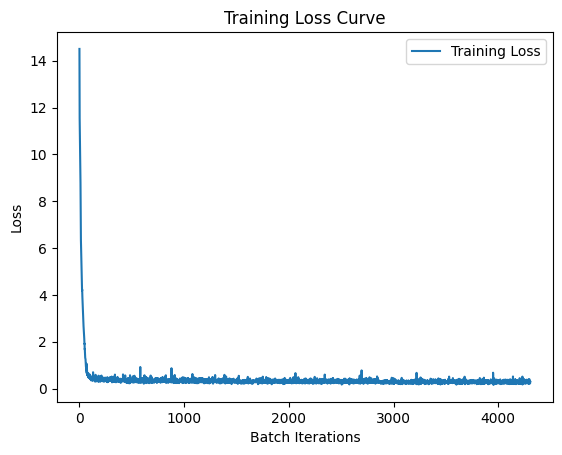

In [ ]:
import torch
from transformers import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
epochs = 3
losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        losses.append(loss.item())  # Store the loss for each batch

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")

# Plot the loss curve
plt.plot(losses, label='Training Loss')
plt.xlabel('Batch Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()


100%|██████████| 359/359 [02:22<00:00,  2.52it/s]

Test Loss: 0.30354278113350563


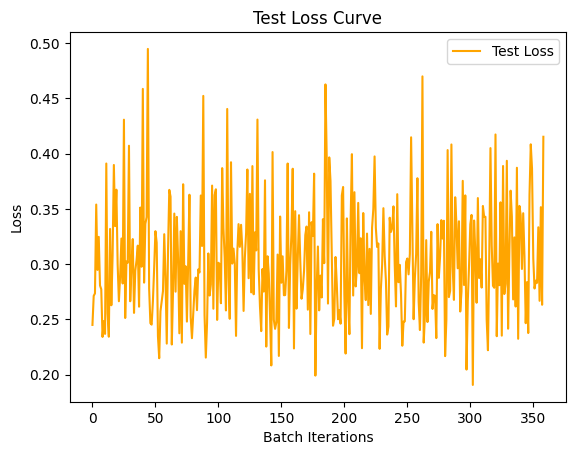

In [ ]:
# Evaluation loop
model.eval()
test_losses = []
total_loss = 0
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        test_losses.append(loss.item())

avg_loss = total_loss / len(test_loader)
print(f"Test Loss: {avg_loss}")

# Plot the test loss curve
plt.plot(test_losses, label='Test Loss', color='orange')
plt.xlabel('Batch Iterations')
plt.ylabel('Loss')
plt.title('Test Loss Curve')
plt.legend()
plt.show()

In [ ]:
def generate_summary(text, model, tokenizer, max_length=512):
    model.eval()
    input_ids = tokenizer.encode(text, return_tensors="pt", max_length=max_length, truncation=True).to(device)

    summary_ids = model.generate(
        input_ids,
        max_length=max_length,
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True
    )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Generate summaries for all test samples
generated_summaries = []
for i in tqdm(range(len(test_df)), desc="Generating Summaries"):
    input_text = test_df.iloc[i]['extractive_summary']
    summary = generate_summary(input_text, model, tokenizer)
    generated_summaries.append(summary)

# Save the generated summaries
test_df['generated_summary'] = generated_summaries
test_df.to_csv("/content/dataset/cnn_dailymail/bart_test_with_summaries.csv", index=False)


Generating Summaries: 100%|██████████| 2871/2871 [33:16<00:00,  1.44it/s]


In [ ]:
!pip install huggingface_hub


In [ ]:
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
The token `write` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pus

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer

# Define save directory
save_directory = "/content/bart_summarization_model"

# Save model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved successfully in {save_directory}!")


Model and tokenizer saved successfully in /content/bart_summarization_model!


In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer

model.push_to_hub("anujKarki/Automatic_text_summarizer")
tokenizer.push_to_hub("anujKarki/Automatic_text_summarizer")

print("Model uploaded to Hugging Face Hub!")


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Model uploaded to Hugging Face Hub!


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import nltk
import numpy as np
import gradio as gr
import networkx as nx
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from transformers import pipeline

# Load the abstractive summarization model
abstractive_summarizer = pipeline("summarization", model="anujKarki/Automatic_text_summarizer")

# Function to vectorize sentences into TF-IDF features
def vectorize_sentences(sentences):
    vectorizer = TfidfVectorizer(stop_words='english')
    return vectorizer.fit_transform(sentences)

# Function to extract central words based on co-occurrence graph and PageRank
def extract_central_words_with_graph(word_list):
    G = nx.Graph()
    for i, word in enumerate(word_list[:-1]):
        for j in range(i + 1, min(len(word_list), i + 5)):  # Co-occurrence window of 5
            G.add_edge(word, word_list[j])

    centrality_scores = nx.pagerank(G)
    central_words = sorted(centrality_scores, key=centrality_scores.get, reverse=True)[:10]
    return central_words

# Function to check if a sentence is complete (ends with punctuation)
def is_complete_sentence(sentence):
    return sentence.strip().endswith(('.', '!', '?'))

# Rank sentences by clustering and central word importance
def rank_sentences_by_clustering(sentences, tfidf_matrix, central_words, top_n_sentences):
    cosine_sim = cosine_similarity(tfidf_matrix)
    distance_matrix = 1 - cosine_sim  # Convert similarity to distance

    n_clusters = min(len(sentences), top_n_sentences)
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
    clusters = clustering_model.fit_predict(distance_matrix)

    ranked_sentences = []
    for cluster in range(n_clusters):
        cluster_indices = [i for i, label in enumerate(clusters) if label == cluster]
        cluster_sentences = [(idx, sentences[idx]) for idx in cluster_indices]

        ranked_cluster_sentences = sorted(
            cluster_sentences,
            key=lambda x: sum(1 for word in word_tokenize(x[1].lower()) if word in central_words),
            reverse=True
        )
        ranked_sentences.extend(ranked_cluster_sentences[:max(1, top_n_sentences // n_clusters)])

    ranked_sentences_sorted = sorted(ranked_sentences, key=lambda x: x[0])
    return [sentence for _, sentence in ranked_sentences_sorted]

# Function to perform extractive summarization
def extractive_summary(input_text):
    sentences = sent_tokenize(input_text)
    # Exclude incomplete sentences
    sentences = [s for s in sentences if is_complete_sentence(s)]

    if not sentences:
        return "No complete sentences found."

    tfidf_matrix = vectorize_sentences(sentences)
    word_list = [word.lower() for sentence in sentences for word in word_tokenize(sentence)]
    central_words = extract_central_words_with_graph(word_list)

    top_n_sentences = max(1, int(len(sentences) * 0.6))  # Reduced
    ranked_sentences = rank_sentences_by_clustering(sentences, tfidf_matrix, central_words, top_n_sentences)

    return " ".join(ranked_sentences)

# Function to perform abstractive summarization
def abstractive_summary(extractive_text):
    if not extractive_text:
        return ""

    word_count = len(extractive_text.split())

    summary = abstractive_summarizer(
        extractive_text,
        max_length=max(50, word_count),  # Ensuring full input is processed
        min_length=max(20, word_count//2 ),
        do_sample=False
    )

    summary_text = summary[0]['summary_text']

    # Remove incomplete sentences from the abstractive summary
    complete_sentences = [s for s in sent_tokenize(summary_text) if is_complete_sentence(s)]
    return " ".join(complete_sentences)

# Combined function
def summarize_text(input_text):
    extracted_summary = extractive_summary(input_text)
    abstractive_result = abstractive_summary(extracted_summary)
    return extracted_summary, abstractive_result

# Gradio Interface
iface = gr.Interface(
    fn=summarize_text,
    inputs=gr.Textbox(label="Input Text"),
    outputs=[
        gr.Textbox(label="Extractive Summary"),
        gr.Textbox(label="Abstractive Summary")
    ],
    title="Hybrid Extractive-Abstractive Text Summarization",
    description="Enter a text passage to generate both extractive and abstractive summaries.",
    theme="default",
   css = """
body, .gradio-container {
    background-color: white !important;
    color: black !important;
}

h1, h2, h3, h4, h5, h6, p, label {
    color: black !important;
}

input, textarea, button, .gr-textbox, .gr-button {
    color: black !important;
    background-color: white !important;
    border: 1px solid black !important;
}

.gr-panel, .gr-block, .gr-group, .gr-box {
    background-color: white !important;
    color: black !important;
    border: 1px solid black !important;

}
"""



)

iface.launch()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/999k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

Device set to use cuda:0


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f0770e744e9314112b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
